In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# -------- 1. LOAD ENV VARIABLES --------
load_dotenv()   # This loads the .env file

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# -------- 2. CREATE ENGINE SAFELY --------
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# -------- 3. TEST CONNECTION --------
with engine.connect() as conn:
    result = conn.execute(text("SELECT 1;")).fetchall()
    print("✅ DB connection OK:", result)

# -------- 4. LOAD SAMPLE FROM dispatch_region_5min --------
query = """
    SELECT *
    FROM dispatch_region_5min
    ORDER BY settlement_ts
    LIMIT 10;
"""


df_sample = pd.read_sql(query, engine)

print("\n📊 Sample rows:")
print(df_sample)

print("\n📋 Columns:", df_sample.columns.tolist())


✅ DB connection OK: [(1,)]

📊 Sample rows:
        settlement_ts region_id  total_demand
0 2025-01-01 00:05:00      TAS1        989.78
1 2025-01-01 00:05:00      NSW1       7251.07
2 2025-01-01 00:05:00      VIC1       4339.00
3 2025-01-01 00:05:00      QLD1       6444.99
4 2025-01-01 00:05:00       SA1       1379.47
5 2025-01-01 00:10:00      QLD1       6469.55
6 2025-01-01 00:10:00      VIC1       4310.79
7 2025-01-01 00:10:00      TAS1        991.04
8 2025-01-01 00:10:00       SA1       1367.61
9 2025-01-01 00:10:00      NSW1       7297.85

📋 Columns: ['settlement_ts', 'region_id', 'total_demand']


In [2]:
df_daily = pd.read_sql("""
    SELECT *
    FROM daily_usage
    ORDER BY date, region_id;
""", engine)

df_daily["date"] = pd.to_datetime(df_daily["date"])
df_daily.head()


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
0,2025-01-01,NSW1,6774.125714,9434.59,4534.57,162014.506667
1,2025-01-01,QLD1,6039.234634,7808.79,4554.92,144438.361667
2,2025-01-01,SA1,862.286655,1518.36,10.55,20623.022500
3,2025-01-01,TAS1,999.820767,1104.47,920.09,23912.380000
4,2025-01-01,VIC1,3293.134390,4488.60,1400.13,78760.797500


In [3]:
df_daily["month"] = df_daily["date"].dt.to_period("M").astype(str)
df_daily.head()


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh,month
0,2025-01-01,NSW1,6774.125714,9434.59,4534.57,162014.506667,2025-01
1,2025-01-01,QLD1,6039.234634,7808.79,4554.92,144438.361667,2025-01
2,2025-01-01,SA1,862.286655,1518.36,10.55,20623.022500,2025-01
3,2025-01-01,TAS1,999.820767,1104.47,920.09,23912.380000,2025-01
4,2025-01-01,VIC1,3293.134390,4488.60,1400.13,78760.797500,2025-01


In [4]:
monthly_group = df_daily.groupby(["month", "region_id"])

df_monthly = monthly_group.agg(
    avg_daily_demand=("avg_5min_demand", "mean"),
    monthly_peak=("daily_peak", "max"),
    monthly_min=("daily_min", "min"),
    total_monthly_energy_mwh=("total_daily_energy_mwh", "sum")
).reset_index()

df_monthly.head()


,month,region_id,avg_daily_demand,monthly_peak,monthly_min,total_monthly_energy_mwh
0,2025-01,NSW1,7230.060644,12128.62,4188.12,5.378601e+06
1,2025-01,QLD1,6716.615186,11159.32,4351.41,4.996658e+06
2,2025-01,SA1,1252.457724,2485.14,10.55,9.317567e+05
3,2025-01,TAS1,968.286454,1213.70,692.39,7.203218e+05
4,2025-01,VIC1,4408.118995,8733.41,1400.13,3.279366e+06


In [5]:
from sqlalchemy import text

# Optional: clear old table
with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS monthly_usage;"))
    print("🧹 Dropped old monthly_usage table (if existed).")

# Write new table
df_monthly.to_sql(
    "monthly_usage",
    engine,
    index=False,
    if_exists="replace"
)

print("✅ monthly_usage table created:", len(df_monthly), "rows")


🧹 Dropped old monthly_usage table (if existed).
✅ monthly_usage table created: 50 rows


### Quick EDA for monthly_usage

In [6]:
df_monthly.describe()


,avg_daily_demand,monthly_peak,monthly_min,total_monthly_energy_mwh
count,50.000000,50.000000,50.000000,5.000000e+01
mean,4251.851725,6525.503400,2130.171400,3.102039e+06
std,2677.039228,4048.013611,1624.185478,1.957243e+06
min,968.286454,1213.700000,-185.490000,6.644999e+05
25%,1254.464256,2200.560000,737.357500,9.135279e+05
50%,4825.838001,8040.945000,2079.885000,3.477741e+06
75%,6544.515883,9463.935000,3482.347500,4.554200e+06
max,8844.295619,13159.460000,5389.370000,6.579298e+06


In [7]:
df_monthly.groupby("region_id")["avg_daily_demand"].mean()


region_id
NSW1    7621.695868
QLD1    6187.103101
SA1     1372.877288
TAS1    1073.342736
VIC1    5004.239634
Name: avg_daily_demand, dtype: float64

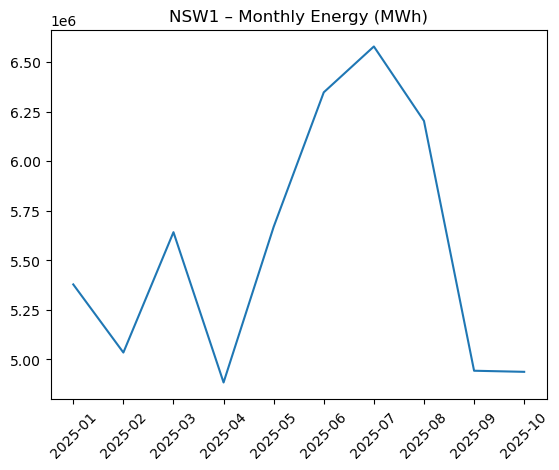

In [8]:
import matplotlib.pyplot as plt

nsw_month = df_monthly[df_monthly["region_id"] == "NSW1"]

plt.plot(nsw_month["month"], nsw_month["total_monthly_energy_mwh"])
plt.xticks(rotation=45)
plt.title("NSW1 – Monthly Energy (MWh)")
plt.show()


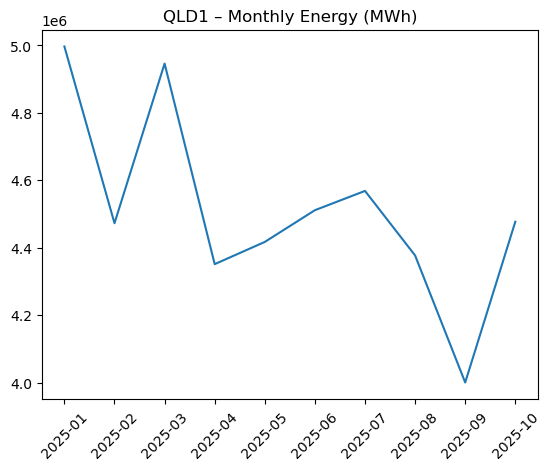

In [9]:
import matplotlib.pyplot as plt

nsw_month = df_monthly[df_monthly["region_id"] == "QLD1"]

plt.plot(nsw_month["month"], nsw_month["total_monthly_energy_mwh"])
plt.xticks(rotation=45)
plt.title("QLD1 – Monthly Energy (MWh)")
plt.show()

In [10]:
from sqlalchemy import text

# Optional: clear old table
with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS monthly_usage;"))
    print("🧹 Dropped old monthly_usage table (if existed).")

# Write new table
df_monthly.to_sql(
    "monthly_usage",
    engine,
    index=False,
    if_exists="replace"
)

print("✅ monthly_usage table created:", len(df_monthly), "rows")


🧹 Dropped old monthly_usage table (if existed).
✅ monthly_usage table created: 50 rows
